In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse 

In [2]:
sample_solution = pd.read_csv('../data/news/BBC News Sample Solution.csv')
train = pd.read_csv('../data/news/BBC News Train.csv')
test = pd.read_csv('../data/news/BBC News Test.csv')

In [3]:
print(train.head())
print(train.info())
print(train.describe())
train['Category'].unique()

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

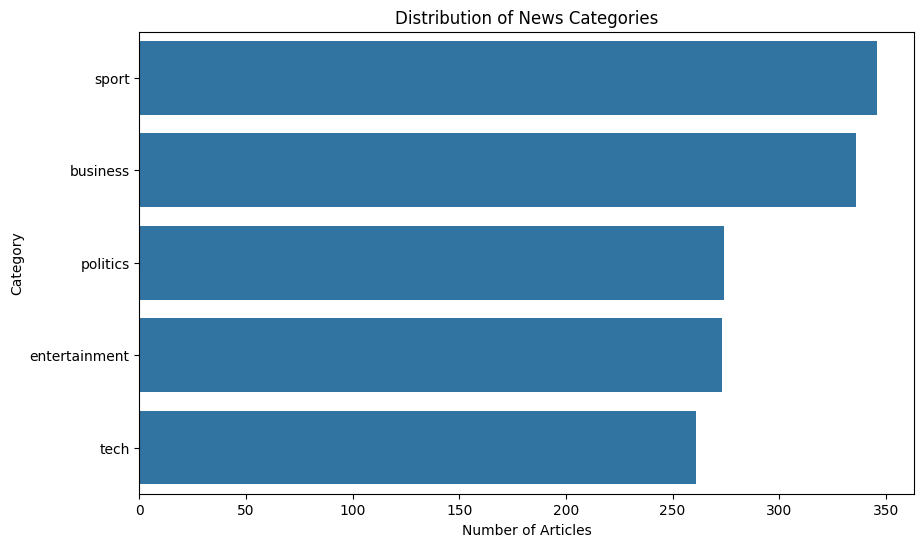

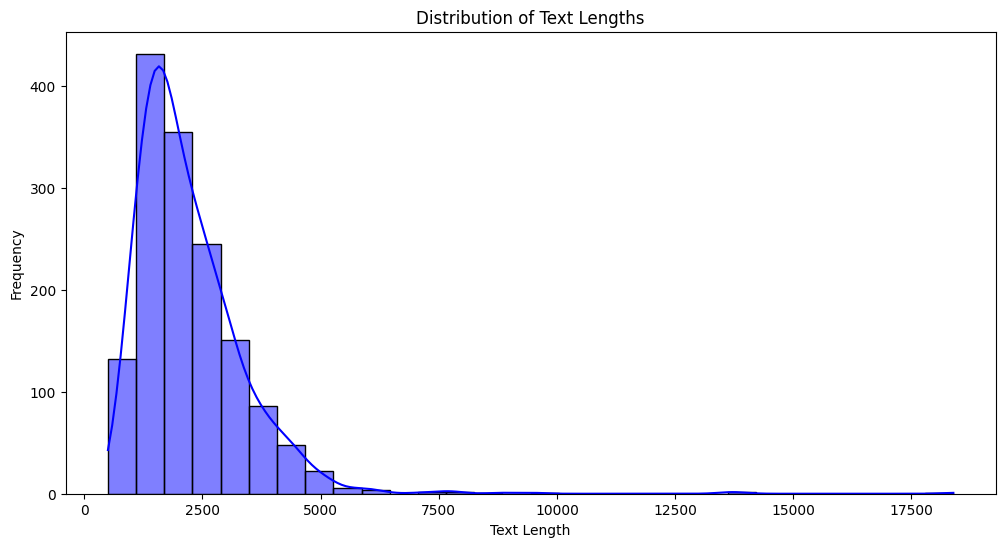

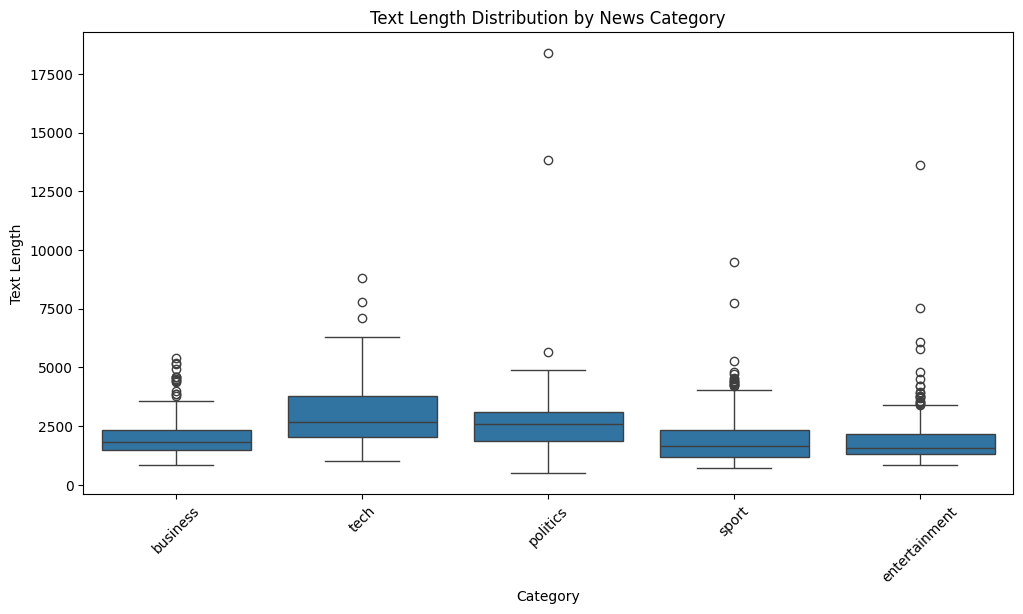

In [4]:
# Visualizing the distribution of news categories
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=train, order = train['Category'].value_counts().index)
plt.title('Distribution of News Categories')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.show()

# Histogram of article lengths
train['Text_Length'] = train['Text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='Text_Length', bins=30, color='blue', kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Text Length by Catgory
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Text_Length', data=train)
plt.title('Text Length Distribution by News Category')
plt.xlabel('Category')
plt.ylabel('Text Length')
plt.xticks(rotation=45)  # Rotating category names for better readability
plt.show()

In [5]:
# Function to plot most common words
def plot_most_common_words(texts, category_name, num_words=10):
    vec = CountVectorizer(stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_words_df = pd.DataFrame(words_freq[:num_words])
    top_words_df.columns=['Word', 'Frequency']

    # Plot
    colors = plt.cm.viridis(np.linspace(0, 1, num_words))  # Generating colors from 'viridis'
    plt.figure(figsize=(10, 5))
    bars = sns.barplot(x='Word', y='Frequency', data=top_words_df)
    for bar, color in zip(bars.patches, colors):
        bar.set_color(color)
    plt.xticks(rotation=45)
    plt.title(f'Most Common Words in {category_name}')
    plt.show()

Category: business


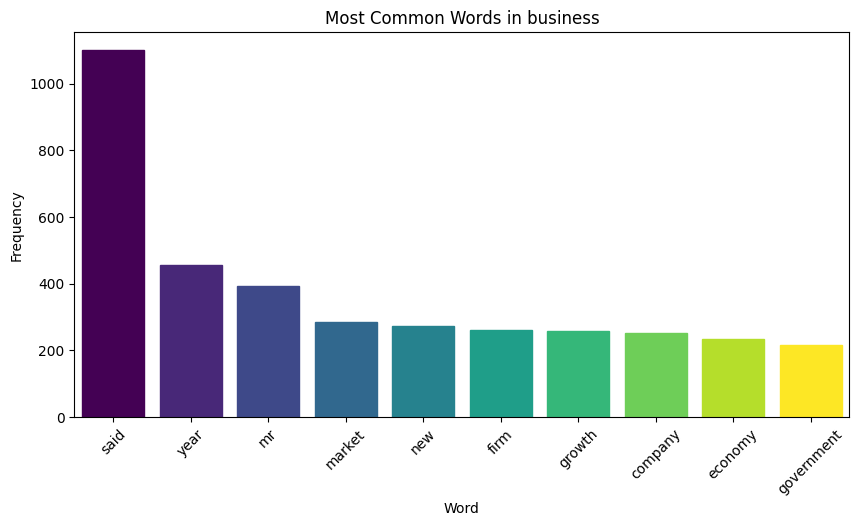

Category: tech


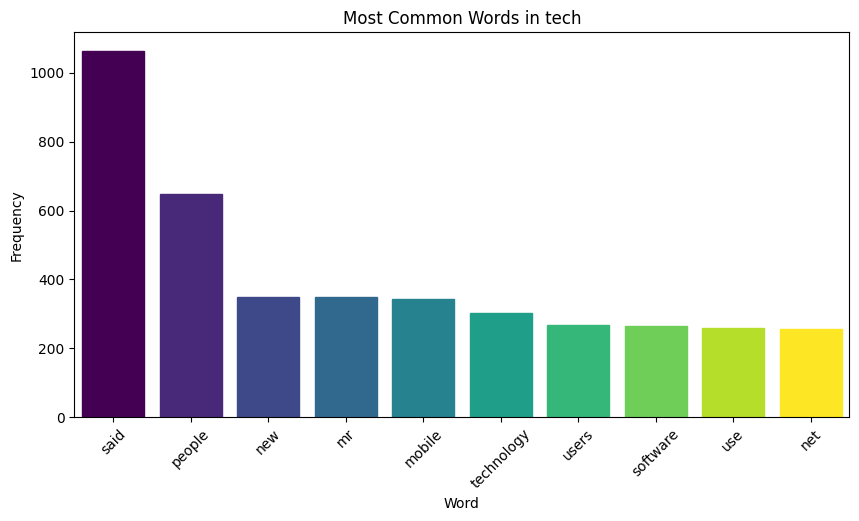

Category: politics


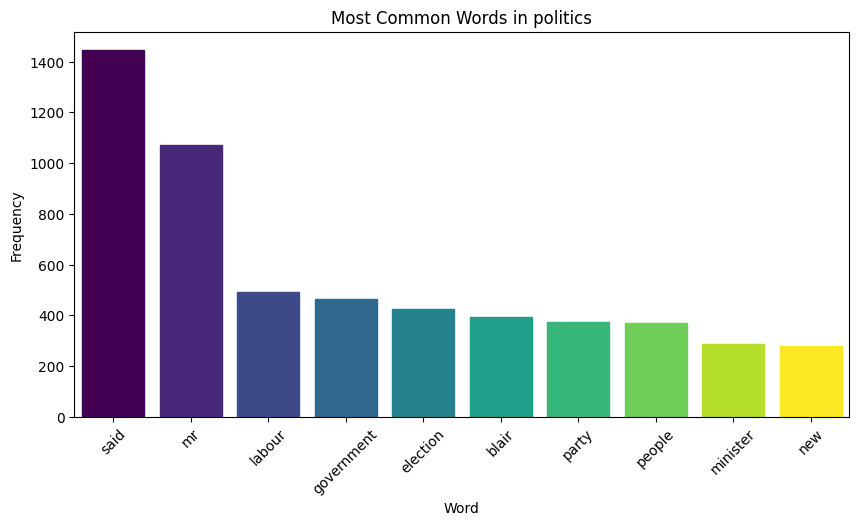

Category: sport


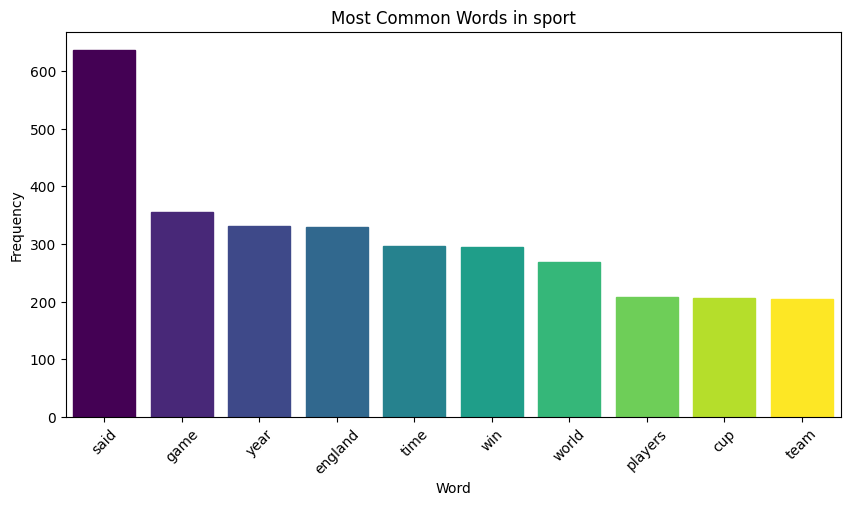

Category: entertainment


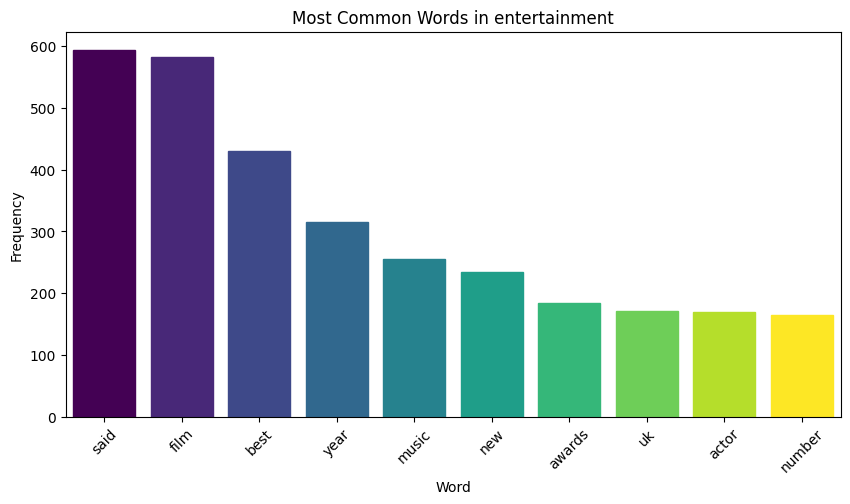

In [6]:
unique_categories = train['Category'].unique()

for category in unique_categories:
    category_text = train[train['Category'] == category]['Text']
    print(f"Category: {category}")
    plot_most_common_words(category_text, category)


In [7]:
# Inspecting sample_solution to see what our goal should be
sample_solution

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


In [8]:
print(sample_solution.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


In [9]:
# Displaying an article's text in the train data to see what we need to do for data cleaning
print(train['Text'][0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
def clean_text(text):
    """ Clean input text by applying several preprocessing steps."""
    # Lowercasing
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[\d\W]+', ' ', text)
    
    # Tokenization
    words = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization (optional, could use stemming instead)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Re-create text from words
    text = ' '.join(words)
    return text

[nltk_data] Downloading package stopwords to /home/panog/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/panog/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# Applying the cleaning function to each text in the dataframe and replacing it with the cleaned text
train['Text'] = train['Text'].apply(clean_text)

# Display the cleaned text to verify
print(train['Text'][0])

worldcom ex bos launch defence lawyer defending former worldcom chief bernie ebbers battery fraud charge called company whistleblower first witness cynthia cooper worldcom ex head internal accounting alerted director irregular accounting practice u telecom giant warning led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charge fraud conspiracy prosecution lawyer argued mr ebbers orchestrated series accounting trick worldcom ordering employee hide expense inflate revenue meet wall street earnings estimate m cooper run consulting business told jury new york wednesday external auditor arthur andersen approved worldcom accounting early said andersen given green light procedure practice used worldcom mr ebber lawyer said unaware fraud arguing auditor alert problem m cooper also said shareholder meeting mr ebbers often passed technical question company finance chief giving brief answer prosecution star witness former worldcom financial chief scott sullivan 

In [12]:
# Calculate word count for each article
train['Word_Count'] = train['Text'].apply(lambda text: len(text.split()))

# Display the first few rows to verify
print(train[['ArticleId', 'Text', 'Word_Count']].head())


   ArticleId                                               Text  Word_Count
0       1833  worldcom ex bos launch defence lawyer defendin...         187
1        154  german business confidence slide german busine...         196
2       1101  bbc poll indicates economic gloom citizen majo...         269
3       1976  lifestyle governs mobile choice faster better ...         345
4        917  enron boss payout eighteen former enron direct...         198


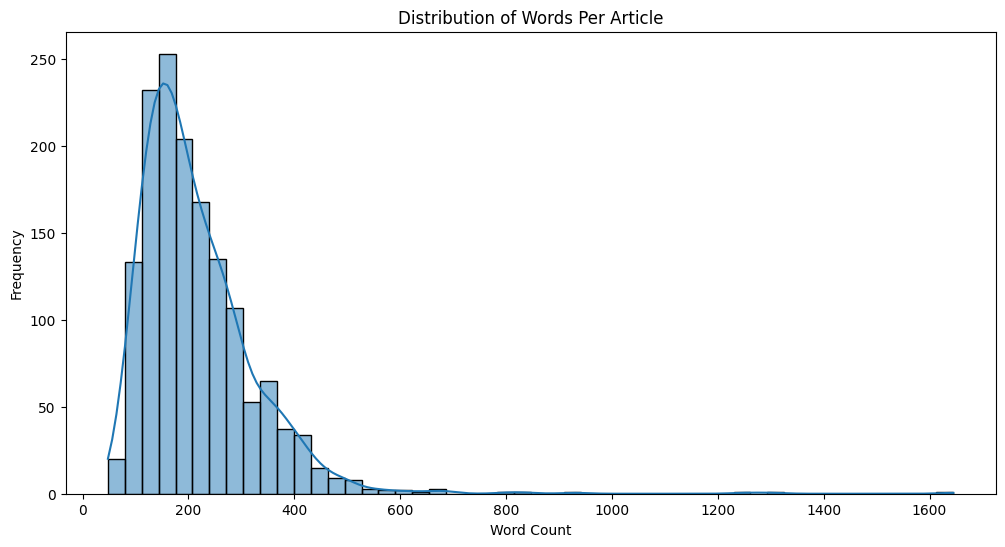

In [13]:
# Visualize Words Per Article
plt.figure(figsize=(12, 6))
sns.histplot(train['Word_Count'], bins=50, kde=True)
plt.title('Distribution of Words Per Article')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

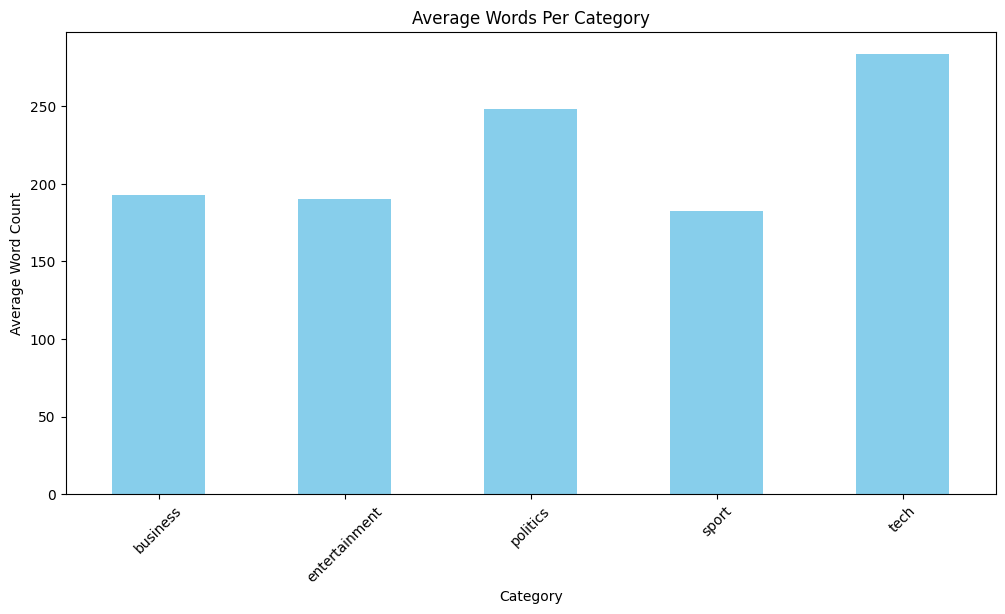

In [14]:
# Calculate and Visualize Average Words Per Category
category_word_counts = train.groupby('Category')['Word_Count'].mean()

plt.figure(figsize=(12, 6))
category_word_counts.plot(kind='bar', color='skyblue')
plt.title('Average Words Per Category')
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.xticks(rotation=45)
plt.show()

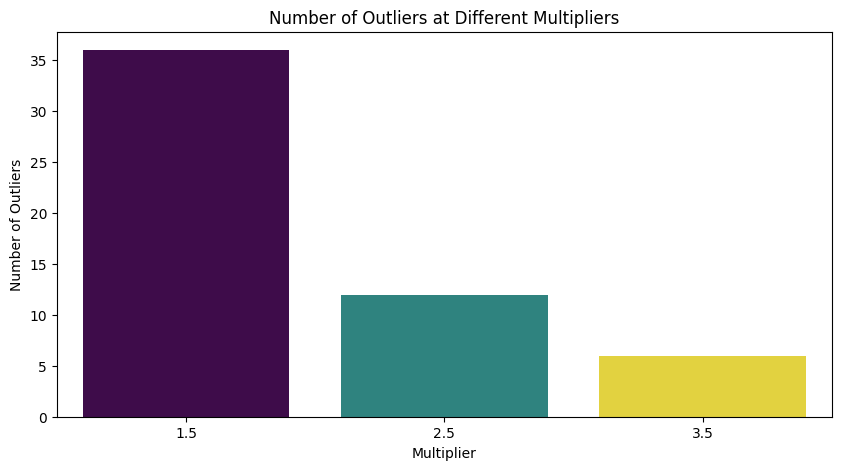

In [17]:
# Identify and Manage Outliers by Visualizing the Effect of Adjusting the Outlier Threshold
# Define outliers using IQR
q1 = train['Word_Count'].quantile(0.25)
q3 = train['Word_Count'].quantile(0.75)
iqr = q3 - q1
multipliers = [1.5, 2.5, 3.5]
outlier_counts = []

for mult in multipliers:
    lower_bound = q1 - mult * iqr
    upper_bound = q3 + mult * iqr
    count = train[(train['Word_Count'] < lower_bound) | (train['Word_Count'] > upper_bound)].shape[0]
    outlier_counts.append(count)

plt.figure(figsize=(10, 5))
sns.barplot(x=multipliers, y=outlier_counts, hue=multipliers, palette="viridis", legend=False)
plt.title('Number of Outliers at Different Multipliers')
plt.xlabel('Multiplier')
plt.ylabel('Number of Outliers')
plt.show()

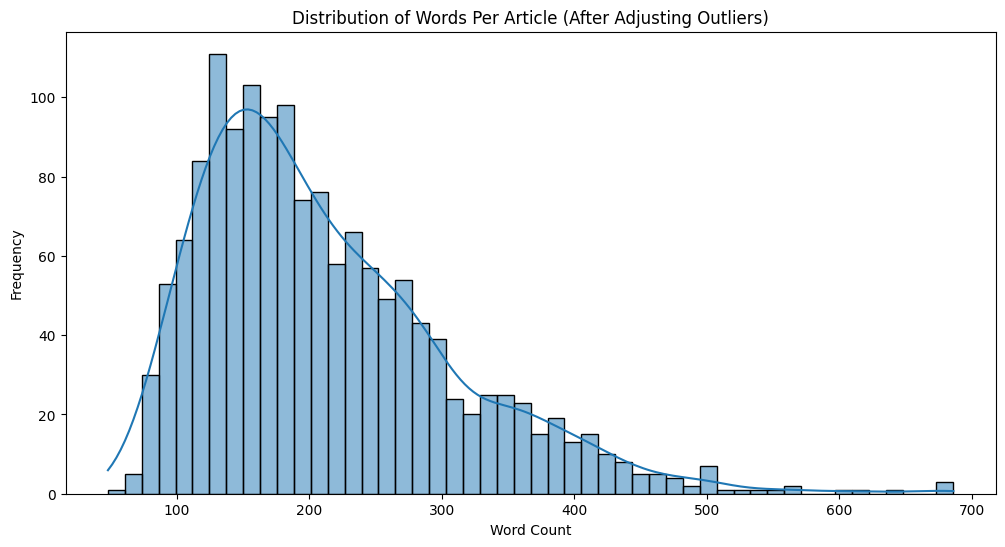

In [18]:
# Applying chosen outlier removal
multiplier = 3.5
lower_bound = q1 - multiplier * iqr
upper_bound = q3 + multiplier * iqr
cleaned_train = train[(train['Word_Count'] >= lower_bound) & (train['Word_Count'] <= upper_bound)]

# Re-checking the distribution without outliers
plt.figure(figsize=(12, 6))
sns.histplot(cleaned_train['Word_Count'], bins=50, kde=True)
plt.title('Distribution of Words Per Article (After Adjusting Outliers)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [19]:
# Drop added columns in cleaned_text
cleaned_train.drop(columns=['Word_Count'], inplace=True)
cleaned_train.drop(columns=['Text_Length'], inplace=True)

/tmp/ipykernel_93236/1425671193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_train.drop(columns=['Word_Count'], inplace=True)
/tmp/ipykernel_93236/1425671193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_train.drop(columns=['Text_Length'], inplace=True)


In [20]:
print(cleaned_train.head())
print(cleaned_train.info())
print(cleaned_train.describe())

   ArticleId                                               Text  Category
0       1833  worldcom ex bos launch defence lawyer defendin...  business
1        154  german business confidence slide german busine...  business
2       1101  bbc poll indicates economic gloom citizen majo...  business
3       1976  lifestyle governs mobile choice faster better ...      tech
4        917  enron boss payout eighteen former enron direct...  business
<class 'pandas.core.frame.DataFrame'>
Index: 1484 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1484 non-null   int64 
 1   Text       1484 non-null   object
 2   Category   1484 non-null   object
dtypes: int64(1), object(2)
memory usage: 46.4+ KB
None
         ArticleId
count  1484.000000
mean   1119.617925
std     642.025502
min       2.000000
25%     564.500000
50%    1112.500000
75%    1681.250000
max    2224.000000


In [21]:
# Analyzing the test data .csv to ensure to apply the same cleaning as train
print(test.head())
print(test.info())
print(test.describe())
print(test['Text'][0])

   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None
         ArticleId
count   735.000000
mean   1099.424490
std     643.925514
min       1.000000
25%     545.500000
50%    1116.000000
75%    1657.500000
max    2225.000000
qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been dis

In [22]:
# Applying our clean_text function on the test data and printing to confirm
test['Text'] = test['Text'].apply(clean_text)
print(test['Text'][0])

qpr keeper day head preston queen park ranger keeper chris day set join preston month loan day displaced arrival simon royce second month loan charlton qpr also signed italian generoso rossi r manager ian holloway said might say risk recalled month simon royce recalled charlton iron fire yes couple others need day ranger contract expires summer meanwhile holloway hoping complete signing middlesbrough defender andy davy either permanently loan saturday match ipswich davy impressed recent loan spell loftus road holloway also chasing bristol city midfielder tom doherty


In [23]:
print(test.head())
print(test.info())
print(test.describe())


   ArticleId                                               Text
0       1018  qpr keeper day head preston queen park ranger ...
1       1319  software watching work software monitor every ...
2       1138  arcy injury add ireland woe gordon arcy ruled ...
3        459  india reliance family feud heat ongoing public...
4       1020  boro suffer morrison injury blow middlesbrough...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None
         ArticleId
count   735.000000
mean   1099.424490
std     643.925514
min       1.000000
25%     545.500000
50%    1116.000000
75%    1657.500000
max    2225.000000


In [24]:
# Save cleaned train and test data to new .csv
cleaned_train.to_csv('../data/news/cleaned_train_data.csv', index=False)
test.to_csv('../data/news/cleaned_test_data.csv', index=False)

In [28]:
# Feature Vectorization for cleaned text data
cleaned_train = pd.read_csv('../data/news/cleaned_train_data.csv')
cleaned_test = pd.read_csv('../data/news/cleaned_test_data.csv')

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 features to avoid overfitting and manage computational complexity

# Fit the vectorizer on the training data and transform both training and test data
tfidf_train = vectorizer.fit_transform(cleaned_train['Text'])
tfidf_test = vectorizer.transform(cleaned_test['Text'])

# Convert the necessary columns to numpy arrays and ensure the TF-IDF matrices are in a format that can be saved
article_ids_train = cleaned_train['ArticleId'].to_numpy()
categories_train = cleaned_train['Category'].to_numpy()
article_ids_test = cleaned_test['ArticleId'].to_numpy()

# Saving Data to .npz file for model building and training
directory = '../data/news'

npz_file_path = os.path.join(directory, 'tfidf_data.npz')
np.savez_compressed(npz_file_path,
                    tfidf_train_data=tfidf_train.data,
                    tfidf_train_indices=tfidf_train.indices,
                    tfidf_train_indptr=tfidf_train.indptr,
                    tfidf_train_shape=tfidf_train.shape,
                    tfidf_test_data=tfidf_test.data,
                    tfidf_test_indices=tfidf_test.indices,
                    tfidf_test_indptr=tfidf_test.indptr,
                    tfidf_test_shape=tfidf_test.shape,
                    article_ids_train=article_ids_train,
                    categories_train=categories_train,
                    article_ids_test=article_ids_test)
print("\nData saved to .npz file at:", npz_file_path)


# Convert sparse matrix to dense matrix for display
tfidf_train_dense = tfidf_train.todense()
tfidf_test_dense = tfidf_test.todense()

# Print the shape and sample of the matrices
print("\nShape of TF-IDF Train Matrix:", tfidf_train.shape)
print("Sample of TF-IDF Train Data (first 5 vectors):\n", tfidf_train_dense[:5])
print("\nShape of TF-IDF Test Matrix:", tfidf_test.shape)
print("Sample of TF-IDF Test Data (first 5 vectors):\n", tfidf_test_dense[:5])


Data saved to .npz file at: ../data/news/tfidf_data.npz

Shape of TF-IDF Train Matrix: (1484, 1000)
Sample of TF-IDF Train Data (first 5 vectors):
 [[0.         0.         0.         ... 0.08965831 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.02857488 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Shape of TF-IDF Test Matrix: (735, 1000)
Sample of TF-IDF Test Data (first 5 vectors):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
